# Finding angles with gradient descent (projections & quaternions)

[Michaël Defferrard](https://deff.ch), EPFL LTS2  
[Laurène Donati](https://people.epfl.ch/laurene.donati), EPFL BIG  
[Jelena Banjac](https://people.epfl.ch/jelena.banjac), EPFL MSc in Data Science

In [1]:
from time import time
import h5py
import os
from sklearn.neighbors import NearestNeighbors
from scipy import stats
import numpy as np, pandas as pd; np.random.seed(0)
import seaborn as sns; sns.set(style="white", color_codes=True)


import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow_graphics.util import asserts
from tensorflow_graphics.math import vector
from tensorflow_graphics.util import safe_ops
from tensorflow_graphics.util import shape
from tensorflow_graphics.geometry.transformation import quaternion, euler

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8894931909779980843
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 96145094720620554
physical_device_desc: "device: XLA_CPU device"
]


---

## Data

In [3]:
n_samples = 5000

In [4]:
# location of *.h5 files
data_dir = "../data"

# half coverage (AngCoverage=0.5)
projections_filename = "bgal_ProjectionsAngles_ProjNber5000_AngCoverage0.25_AngShift0.00"

# load structures
data = h5py.File(os.path.join(data_dir, f"{projections_filename}.h5"), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (136, 136) pixels
5000 sets of 3 ground truth angles of corresponding projection images


##### Angles

###### Predicted Angles

In [5]:
# [x, y, z]
euler = np.random.uniform(low= [0,       0,       0], 
                          high=[2*np.pi, 2*np.pi, 2*np.pi],
                          size=(n_samples, 3))

# angles_predicted = [tf.Variable(e) for e in euler]
# x, y, z = tf.split(angles_predicted, 3, axis=1)
# x = tf.clip_by_value(x, 0, np.pi/4)
# y = tf.clip_by_value(y, 0, np.pi/4)
# z = tf.clip_by_value(z, 0, 2*np.pi)
# angles_predicted = tf.concat([x, y, z], axis=1)

# angles_predicted = [tf.Variable(e, constraint=lambda x: tf.clip_by_value(x, low_ang, high_ang)) for e in euler]
angles_predicted = [tf.Variable(e) for e in euler]
print(f"Angles predicted: length = {len(angles_predicted)} (min, max) = ({tf.reduce_min(angles_predicted):.4f}, {tf.reduce_max(angles_predicted):.4f})")
angles_predicted = np.array(angles_predicted)

Angles predicted: length = 5000 (min, max) = (0.0005, 6.2830)


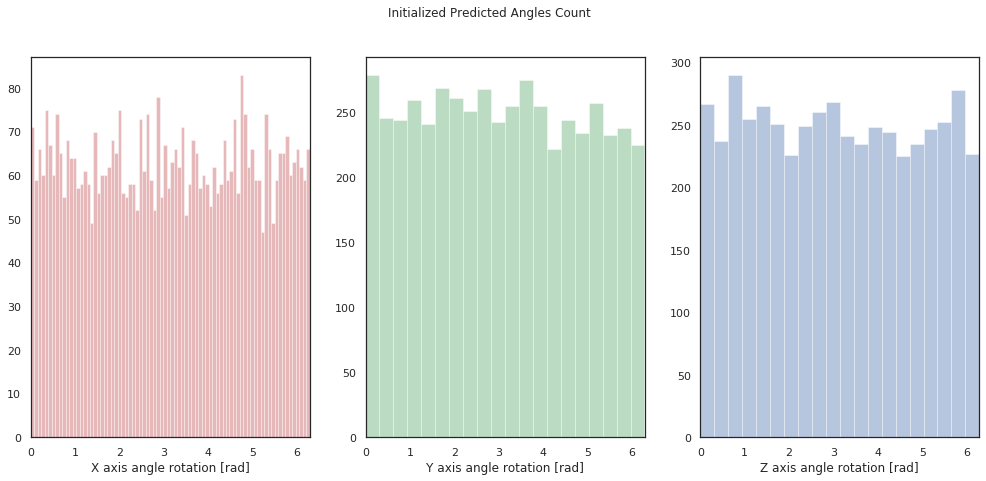

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,2*np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("Initialized Predicted Angles Count")

sns.distplot(euler[:,0], kde=False, bins=80, ax=axs[0], axlabel="X axis angle rotation [rad]", color="r")
sns.distplot(euler[:,1], kde=False, bins=20, ax=axs[1], axlabel="Y axis angle rotation [rad]", color="g")
sns.distplot(euler[:,2], kde=False, bins=20, ax=axs[2], axlabel="Z axis angle rotation [rad]", color="b");

###### True Angles

In [7]:
angles_true = np.reshape(data["Angles"], (data["Angles"].shape[0], -1))
print(f"Angles true: length = {len(angles_true)} (min, max) = ({np.min(angles_true):.4f}, {np.max(angles_true):.4f})")
angles_true = np.array(angles_true)

Angles true: length = 5000 (min, max) = (0.0000, 3.1410)


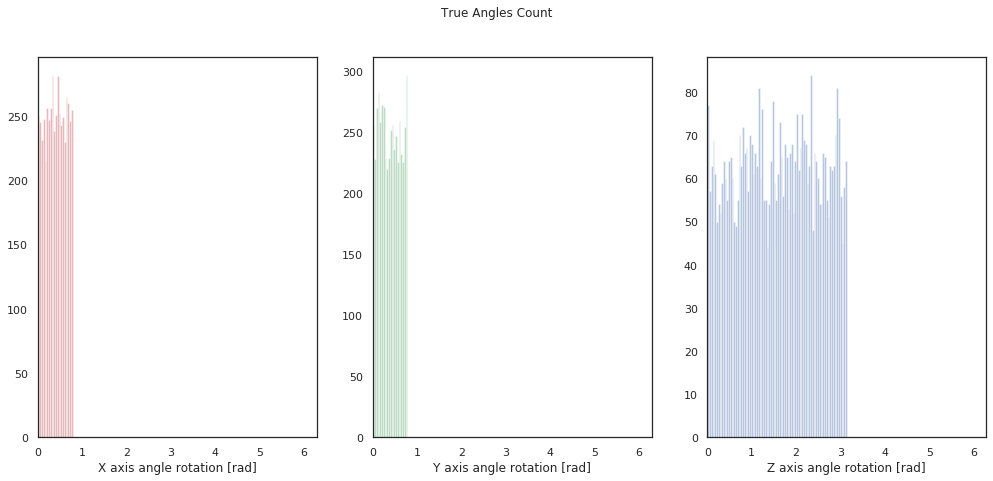

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,2*np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("True Angles Count")

sns.distplot(angles_true[:,0], kde=False, bins=20, ax=axs[0], axlabel="X axis angle rotation [rad]", color="r")
sns.distplot(angles_true[:,1], kde=False, bins=20, ax=axs[1], axlabel="Y axis angle rotation [rad]", color="g")
sns.distplot(angles_true[:,2], kde=False, bins=80, ax=axs[2], axlabel="Z axis angle rotation [rad]", color="b");

##### Projections

In [9]:
projections = np.reshape(data["Projections"], (data["Projections"].shape[0], -1))
print(f"Projections: lenght = {len(projections)} (min, max) = ({np.min(projections):.4f}, {np.max(projections):.4f})")
projections = np.array(projections)

Projections: lenght = 5000 (min, max) = (0.0000, 17.7208)


In [10]:
n_pixels = projections.shape[1]

---

## Distances

##### Angle Distances

In [11]:
def d_q(q1, q2):
     with (tf.compat.v1.name_scope(None, "quaternion_relative_angle",
                                 [q1, q2])):
        q1 = tf.convert_to_tensor(value=q1)
        q2 = tf.convert_to_tensor(value=q2)
      
        shape.check_static(
            tensor=q1, tensor_name="quaternion1", has_dim_equals=(-1, 4))
        shape.check_static(
            tensor=q2, tensor_name="quaternion2", has_dim_equals=(-1, 4))

        q1 = quaternion.normalize(q1)
        q2 = quaternion.normalize(q2)
        
        dot_product = vector.dot(q1, q2, keepdims=False)
        
        # Ensure dot product is in range [-1. 1].
        const = 1.8 #4.0 #.63
        eps_dot_prod = const * asserts.select_eps_for_addition(dot_product.dtype)
        dot_product = safe_ops.safe_shrink(
            dot_product, -1, 1, open_bounds=False, eps=eps_dot_prod)

        return 2.0 * tf.acos(tf.abs(dot_product))   #1 - tf.abs(dot_product)
    
assert tf.reduce_mean(d_q(quaternion.from_euler(angles_true[0:3]), quaternion.from_euler(angles_true[0:3]))) < 1e-7
assert (d_q(quaternion.from_euler([np.pi/2]*3), quaternion.from_euler([2*np.pi-np.pi/2]*3))-np.pi) < 1e-7

##### Projection Distance

In [12]:
def d_p(p1, p2):
    # (learned) distance between two images.
    # for now, Euclid dist
    p1 = tf.convert_to_tensor(value=p1, dtype=np.float64)
    p2 = tf.convert_to_tensor(value=p2, dtype=np.float64)

    if len(p1.shape) > 1:
        dist = tf.norm(p1-p2, ord='euclidean', axis=1, keepdims=True)
    else:
        dist = tf.norm(p1-p2, ord='euclidean')

    return dist

assert tf.reduce_mean(d_p(projections[0:3], projections[0:3])) < 1e-7

---

## Compare d_Q and d_P

###### k-NN

In [13]:
k = 5

In [14]:
indices_p     = np.load(f'data/{projections_filename}_indices.npy')     # shape: NUM_IMGS, NUM_NEIGHBOURS
distances_p   = np.load(f'data/{projections_filename}_distances.npy')   # shape: NUM_IMGS, NUM_NEIGHBOURS

In [15]:
indices_p[0]

array([   0, 3537,   23, 4344, 4228])

In [16]:
q1 = quaternion.from_euler(angles_true[0])
q2 = quaternion.from_euler(angles_true[989])

print(angles_true[0])
print(angles_true[989])
print(q1)
print(q2)
d_q(q1, q2).numpy(), d_q(q1, -q2).numpy(), d_q(-q1, q2).numpy(), d_q(-q1, -q2).numpy()

[0.17811083 0.46789269 1.21639374]
[0.26597764 0.49871062 0.31917761]
tf.Tensor([-0.06093224  0.23892822  0.53670059  0.80694055], shape=(4,), dtype=float64)
tf.Tensor([0.08799335 0.26191161 0.12033116 0.95350925], shape=(4,), dtype=float64)


(0.9415213874345745,
 0.9415213874345745,
 0.9415213874345745,
 0.9415213874345745)

In [17]:
q1 = quaternion.from_euler(angles_true[0])
q2 = quaternion.from_euler(angles_true[4659])

print(angles_true[0])
print(angles_true[4659])
print(q1)
print(q2)
d_q(q1, q2).numpy(), d_q(q1, -q2).numpy(), d_q(-q1, q2).numpy(), d_q(-q1, -q2).numpy()

[0.17811083 0.46789269 1.21639374]
[0.21475823 0.4394356  2.69882876]
tf.Tensor([-0.06093224  0.23892822  0.53670059  0.80694055], shape=(4,), dtype=float64)
tf.Tensor([-0.18844327  0.14962598  0.94152763  0.23585361], shape=(4,), dtype=float64)


(1.4668966042921616,
 1.4668966042921616,
 1.4668966042921616,
 1.4668966042921616)

In [18]:
d_p_list = []
d_q_list = []

for indices in indices_p:
    for jidx, j in enumerate(indices[1:], start=1):
        i = indices[0]
        distance_target_p = distances_p[i][jidx] 

        d_p_list.append(distance_target_p)

        a1 = angles_true[i]
        a2 = angles_true[j]
        q1 = quaternion.from_euler(a1)
        q2 = quaternion.from_euler(a2)
        
        distance_target_q = d_q(q1, q2)
        d_q_list.append(distance_target_q)

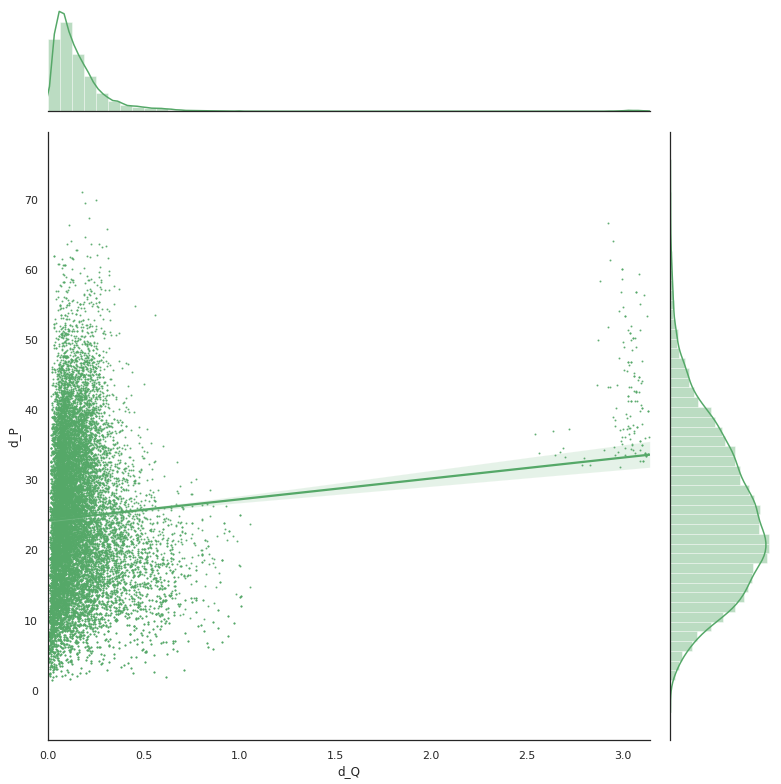

In [19]:
data = {"d_Q" : [x.numpy() for x in d_q_list],
        "d_P" : d_p_list}
df = pd.DataFrame(data=data)
#df = df[df.d_P < 15]

sns.jointplot(xlim=(0,np.pi), x="d_Q", y="d_P", data=df, kind="reg", color="g", height=11, scatter_kws={"s": 1})  # "reg", "kde"

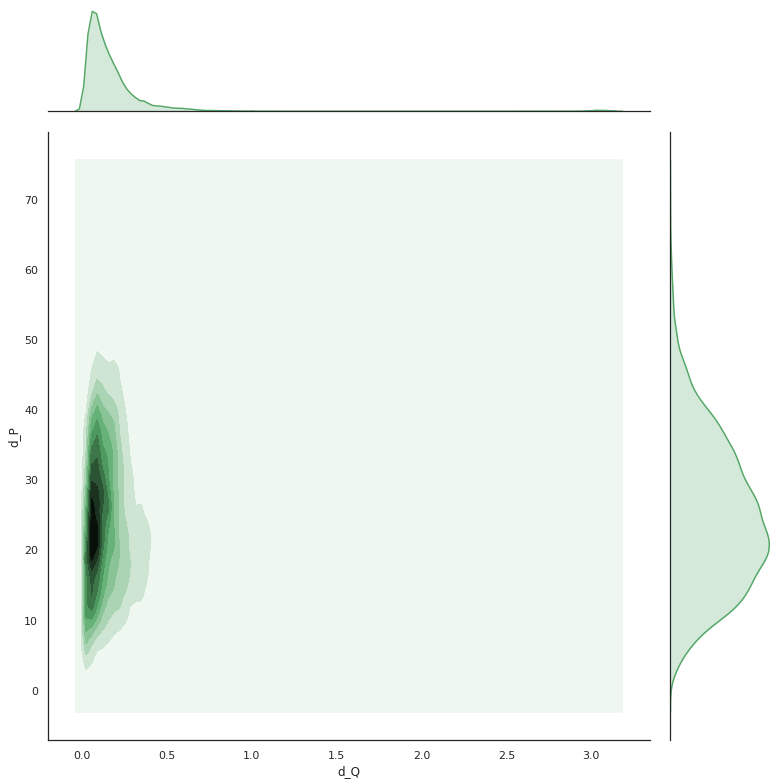

In [20]:
sns.jointplot(x="d_Q", y="d_P", data=df, kind="kde", color="g", height=11)  # "reg", "kde"

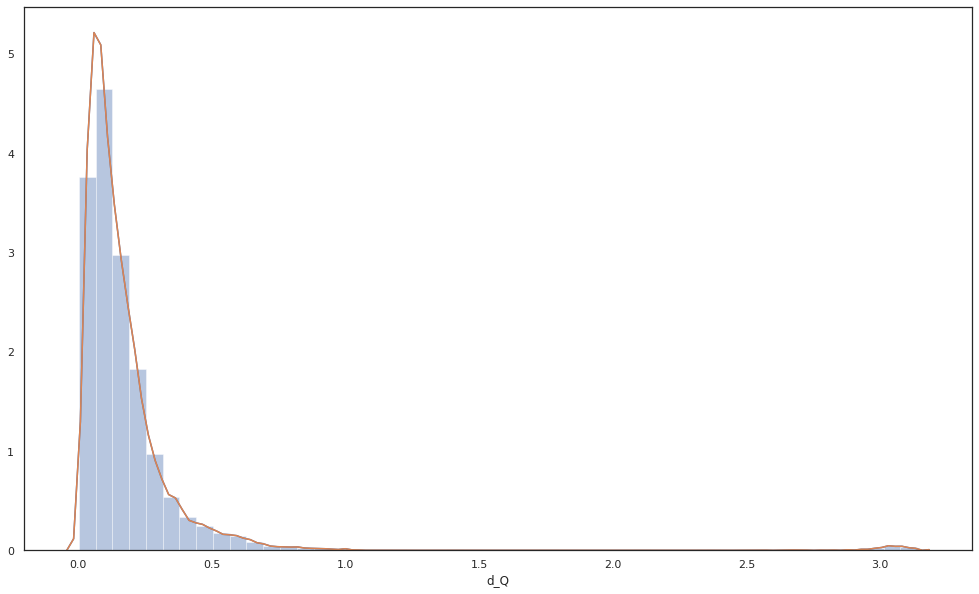

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(17,10))
g = sns.distplot(df["d_Q"], ax=ax);

X=g.get_lines()[0].get_xdata()# x-coordinate of points along the regression line
Y=g.get_lines()[0].get_ydata()# y-coordinate
plt.plot(X, Y)


In [22]:
df.describe()

,d_Q,d_P
count,20000.000000,20000.000000
mean,0.179130,24.738616
std,0.272452,10.609147
min,0.003180,1.386703
25%,0.068590,16.778526
50%,0.120974,23.771297
75%,0.205940,31.956509
max,3.138411,70.985670


In [23]:
dQ_mean = df.describe().iloc[1,0]
dP_mean = df.describe().iloc[1,1]
slope = dP_mean/dQ_mean
intercept = 0

In [24]:
#slope, intercept, r_value, p_value, slope_std_error = stats.linregress(df["d_Q"],df["d_P"])
print(f"d_P/d_Q = {slope}, intercept = {intercept}")
# dP = slope*dQ + intercept
# => dQ = (dP-intercept)/slope

d_P/d_Q = 138.1042050053585, intercept = 0


---

#### Observing just the distances of one projection to all the other ones

Text(0, 0.5, 'd_P')

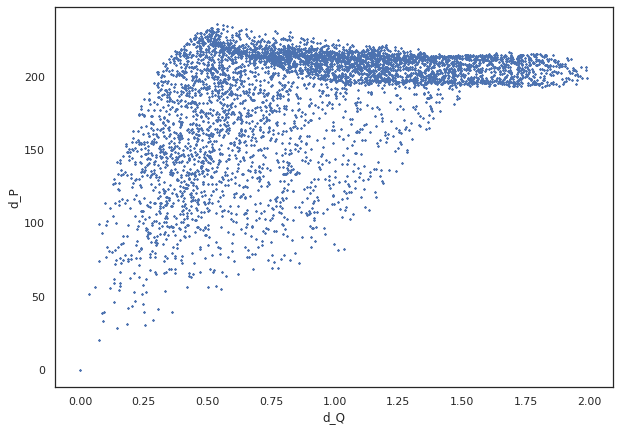

In [25]:
# Plot convergence.
all_q_dist = []
all_p_dist = []
time_start = time()

plt.figure(figsize=(10,7))


d_q_list = []
d_p_list = []

i = 0

# Sample some pairs.
idx1 = list([i]*5000)
idx2 = list(range(5000))
a1 = [angles_true[i] for i in idx1]
a2 = [angles_true[i] for i in idx2]
q1 = quaternion.from_euler(a1)
q2 = quaternion.from_euler(a2)
distance_target_q = d_q(q1, q2)
d_q_list.append(distance_target_q)

# Compute distances between projections
p1 = [projections[i] for i in idx1]
p2 = [projections[i] for i in idx2]
distance_target_p = d_p(p1, p2)
d_p_list.append(distance_target_p)

plt.plot(d_q_list[0], d_p_list[0], marker="*", markersize=2, lw=0)   
plt.xlabel('d_Q')
plt.ylabel('d_P')

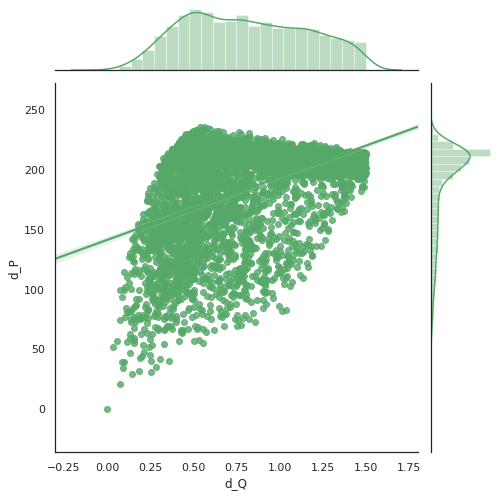

In [26]:

data = {"d_Q" : list(d_q_list[0].numpy()),
        "d_P" : [x for x in d_p_list[0].numpy().T[0]]}
df = pd.DataFrame(data=data)
df = df[df.d_Q < 1.5]

sns.jointplot(x="d_Q", y="d_P", data=df, kind="reg", color="g", height=7)  # "reg", "kde"

In [27]:
# slope, intercept, r_value, p_value, slope_std_error = stats.linregress(df["d_Q"],df["d_P"])
# print(f"d_P/d_Q = {slope}, intercept = {intercept}")
# # dP = slope*dQ + intercept
# # => dQ = (dP-intercept)/slope

###### All

Step 0/5000 (0s)


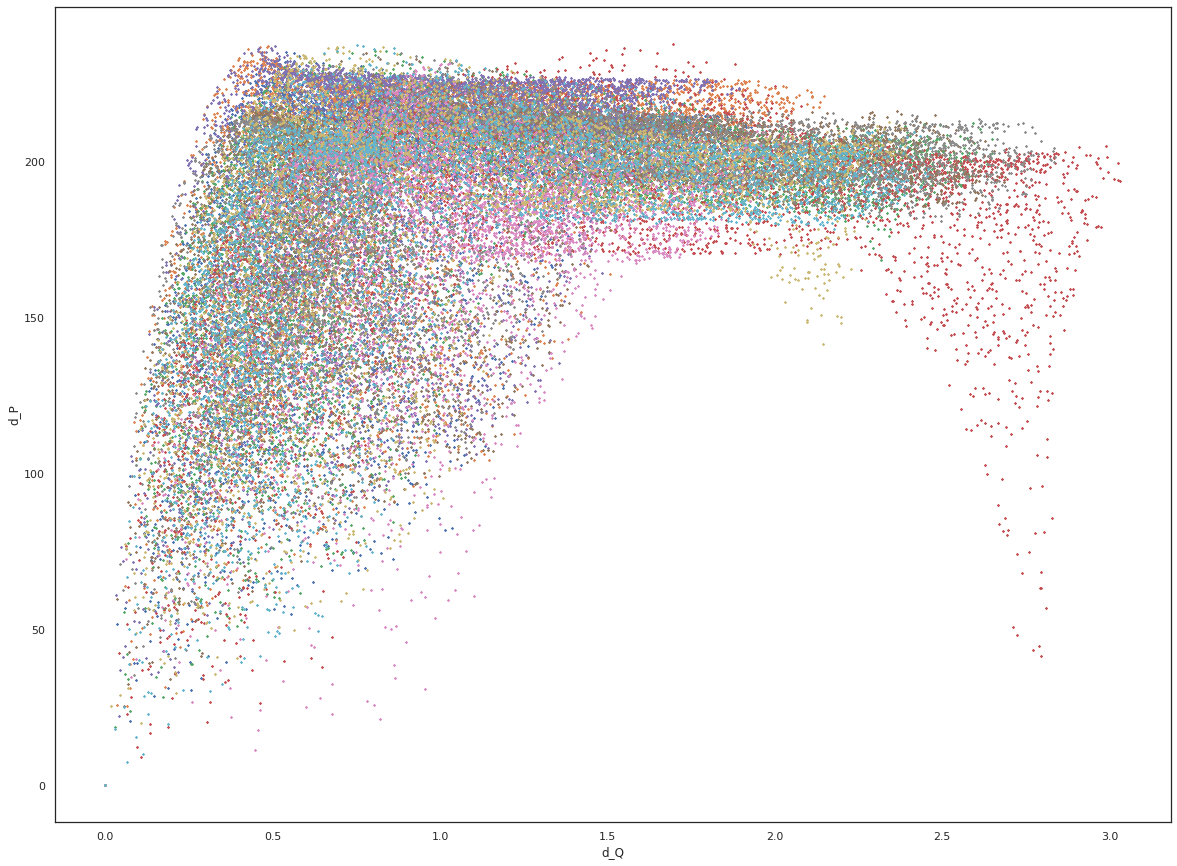

In [36]:
# Plot convergence.
all_q_dist = []
all_p_dist = []
time_start = time()

plt.figure(figsize=(20,15))

ITERATIONS = 5000

for i in range(0, ITERATIONS, 500):
    if i//100==0:
        time_elapsed = time() - time_start
        print(f"Step {i}/{ITERATIONS} ({time_elapsed:.0f}s)")
    d_q_list = []
    d_p_list = []

    # Sample some pairs.
    idx1 = list([i]*5000)
    idx2 = list(range(5000))
    a1 = [angles_true[i] for i in idx1]
    a2 = [angles_true[i] for i in idx2]
    q1 = quaternion.from_euler(a1)
    q2 = quaternion.from_euler(a2)
    distance_target_q = d_q(q1, q2)
    d_q_list.append(distance_target_q)

    # Compute distances between projections
    p1 = [projections[i] for i in idx1]
    p2 = [projections[i] for i in idx2]
    distance_target_p = d_p(p1, p2)
    d_p_list.append(distance_target_p)
    
    all_q_dist.extend(d_q_list)
    all_p_dist.extend(d_p_list)
    
    plt.plot(d_q_list[0], d_p_list[0], marker="*", markersize=2, lw=0)
    
plt.xlabel('d_Q')
plt.ylabel('d_P');

In [37]:
all_q_dist = [x.numpy() for x in all_q_dist]
new_all_q = []
for x in all_q_dist:
    new_all_q.extend(x)

In [38]:
all_p_dist = [x.numpy() for x in all_p_dist]
new_all_p = []
for x in all_p_dist:
    new_all_p.extend(x)
new_all_p = [x[0] for x in new_all_p]

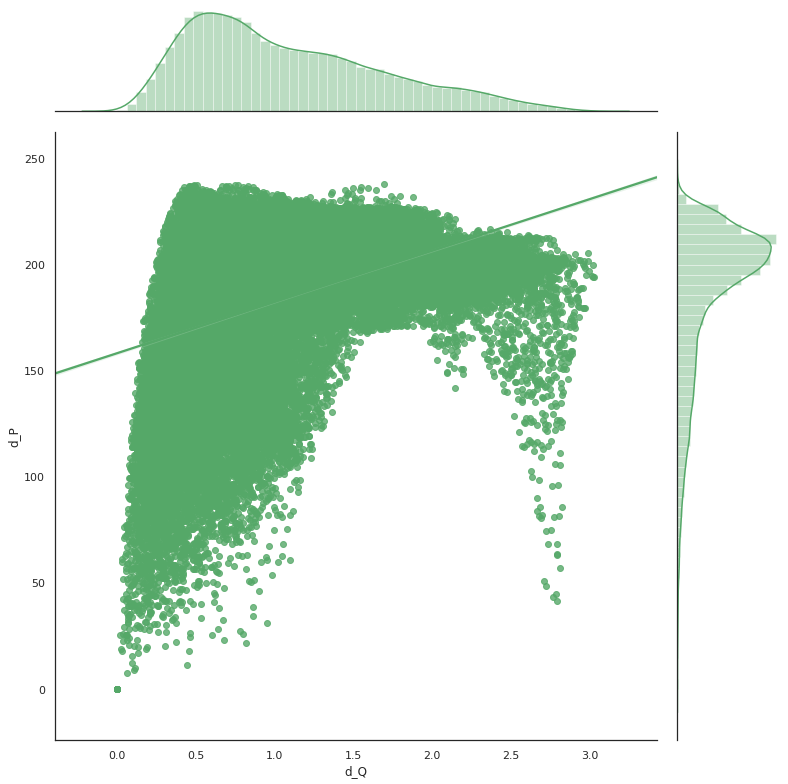

In [39]:
data = {"d_Q" : np.asarray(new_all_q),
        "d_P" : np.asarray(new_all_p)}
df = pd.DataFrame(data=data)

sns.jointplot(x="d_Q", y="d_P", data=df, kind="reg", color="g", height=11)  # "reg", "kde"

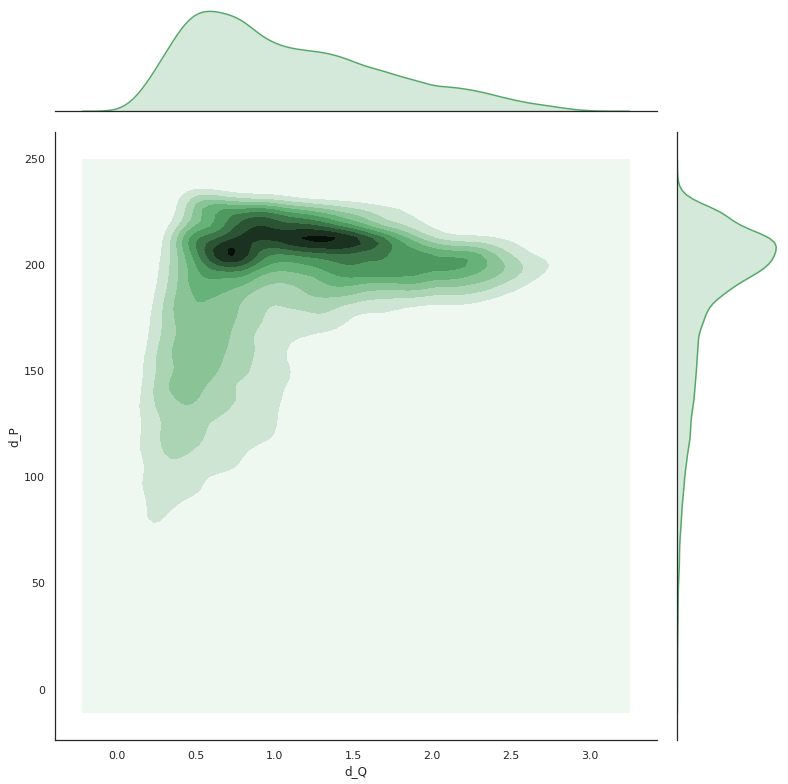

In [40]:
sns.jointplot(x="d_Q", y="d_P", data=df, kind="kde", color="g", height=11)

---

---

## Loss and gradient

Our goal is to then optimize
$$ \operatorname*{arg\,min}_{\{\hat{Q}_i\}_{i=1}^n} \sum_{\{i,j |d_p(p_i, p_j) < \epsilon\}} \left| d_p(p_i, p_j) - d_Q(\hat{Q}_i, \hat{Q}_j) \right|^2, $$
where $p_i$ is a projected image and $d_p$ is a (learned) distance between two images.

In [17]:
def loss(a1_predicted, a2_predicted, distance_target, normalize=None):
    a1_predicted = list(a1_predicted)
    a2_predicted = list(a2_predicted)
    
    q1 = quaternion.from_euler(a1_predicted)
    q2 = quaternion.from_euler(a2_predicted)
    
    distance = d_q(q1, q2)
    
    if normalize:
        #distance = normalize_quaternion_distance(distance)
        #distance_target = normalize_projection_distance(distance_target)
        distance_target = (distance_target-intercept)/slope
        #distance_target = np.abs(distance_target-55)
    
    # The mean doesn't depend on the batch size.
    return tf.reduce_mean((distance - distance_target)**2)

In [18]:
def gradient(a1_predicted, a2_predicted, distance_target, normalize=None):
    with tf.GradientTape() as tape:
        loss_value = loss(a1_predicted, a2_predicted, distance_target, normalize)
        gradient = tape.gradient(loss_value, a1_predicted + a2_predicted)
        
    return loss_value, gradient

---

In [19]:
def loss_predicted_vs_true_angle(steps, batch_size, optimization=False):
    losses = np.empty(steps)
    time_start = time()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    
    for step in range(1, steps+1):

        # Sample some pairs.
        idx1 = list(np.random.randint(0, n_samples, batch_size))
        idx2 = list(np.random.randint(0, n_samples, batch_size))
        a1 = [angles_predicted[i] for i in idx1]
        a2 = [angles_predicted[i] for i in idx2]

        # Compute distances between true quaternions
        a1_true = [angles_true[i] for i in idx1]
        a2_true = [angles_true[i] for i in idx2]
        q1_true = quaternion.from_euler(a1_true)
        q2_true = quaternion.from_euler(a2_true)
        
        distance_target = d_q(q1_true, q2_true)

        # Optimize by gradient descent.
        if optimization:
            losses[step-1], gradients = gradient(a1, a2, distance_target, normalize=False)
            optimizer.apply_gradients(zip(gradients, a1 + a2))
        else:
            losses[step-1] = loss(a1, a2, distance_target)
        
        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time() - time_start
            print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')

    if optimization:
        # Plot convergence.
        fig, ax = plt.subplots()
        ax.plot(np.linspace(0, time()-time_start, steps), losses)
        ax.set_xlabel('time [s]')
        ax.set_ylabel('loss');
    else:
        print(f"Mean loss: {np.mean(losses)}")

In [20]:
def get_knn_output(k=5, print_timer=False):
    start_time = time()

    if not os.path.exists(f'data/{projections_filename}_distances.npy'):
        nbrs = NearestNeighbors(n_neighbors=k, metric=d_p, algorithm='ball_tree').fit(projections)
        distances_p, indices_p = nbrs.kneighbors(projections)
        A_p = nbrs.kneighbors_graph(projections).toarray()

        np.save(f'data/{projections_filename}_indices', indices_p)         # Indices of the nearest points in the population matrix
        np.save(f'data/{projections_filename}_distances', distances_p)     # Array representing the lengths to points
        np.save(f'data/{projections_filename}_A', A_p)                     # Sparse graph showing the connections between neighboring points

    else:
        indices_p     = np.load(f'data/{projections_filename}_indices.npy')     # shape: NUM_IMGS, NUM_NEIGHBOURS
        distances_p   = np.load(f'data/{projections_filename}_distances.npy')   # shape: NUM_IMGS, NUM_NEIGHBOURS
        A_p           = np.load(f'data/{projections_filename}_connections.npy')           # shape: NUM_IMGS, NUM_IMGS

    if print_timer:
        print(f"--- {time() - start_time} seconds ---")
    
    return indices_p, distances_p, A_p

In [21]:
def sample_pairs(n_samples, batch_size, style="random"):
    if style=="random":
        idx1 = list(np.random.randint(0, n_samples, batch_size))
        idx2 = list(np.random.randint(0, n_samples, batch_size))
    
    elif style=="knn":
        k = 5
        idx1 = list(np.random.randint(0, n_samples, batch_size))
        indices_p, distances_p, A_p = get_knn_output(k=k)
        idx2 = [indices_p[i][np.random.randint(1, k)] for i in idx1]
 
    return idx1, idx2

In [22]:
indices_p, distances_p, A_p = get_knn_output(k=k, print_timer=True)

--- 0.03274989128112793 seconds ---


In [23]:
np.max(distances_p)

70.98566963697401

## Optimization loop (projection-true & angles-predict)

In [26]:
print(f"Slope = {slope}, intercept = {intercept}")
slope, intercept = 300, 0

Slope = 300, intercept = 0


### [Before] Prediction vs. True Angles

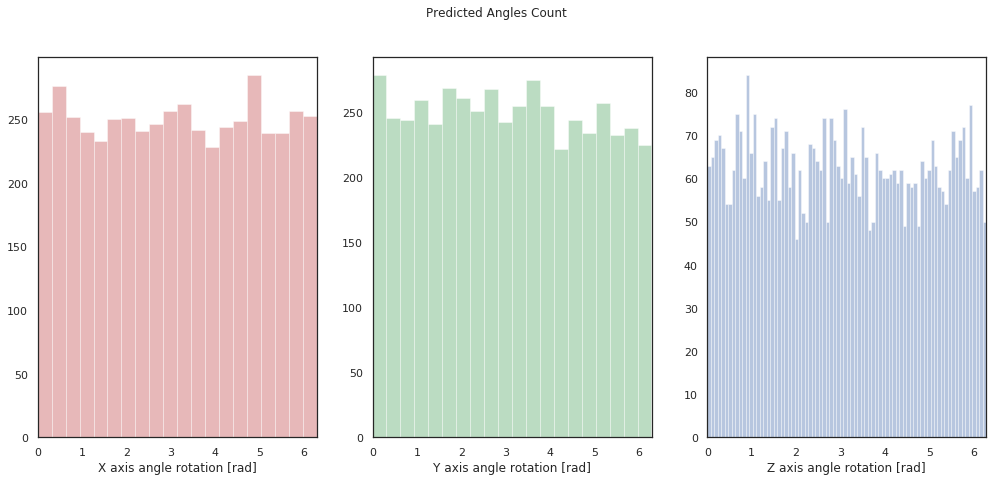

In [27]:
_angles_predicted = np.array([x.numpy() for x in angles_predicted])

fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,2*np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("Predicted Angles Count")

sns.distplot(_angles_predicted[:,0], kde=False, bins=20, ax=axs[0], axlabel="X axis angle rotation [rad]", color="r")
sns.distplot(_angles_predicted[:,1], kde=False, bins=20, ax=axs[1], axlabel="Y axis angle rotation [rad]", color="g")
sns.distplot(_angles_predicted[:,2], kde=False, bins=80, ax=axs[2], axlabel="Z axis angle rotation [rad]", color="b");

In [28]:
loss_predicted_vs_true_angle(steps=2000, batch_size=256)

step 200/2000 (2s): loss = 1.78e+00
step 400/2000 (3s): loss = 1.88e+00
step 600/2000 (5s): loss = 2.09e+00
step 800/2000 (7s): loss = 1.91e+00
step 1000/2000 (9s): loss = 2.09e+00
step 1200/2000 (10s): loss = 2.08e+00
step 1400/2000 (12s): loss = 1.95e+00
step 1600/2000 (14s): loss = 1.96e+00
step 1800/2000 (15s): loss = 1.95e+00
step 2000/2000 (17s): loss = 1.98e+00
Mean loss: 1.984279768914404


step 500/5000 (468s): loss = 2.76e+00
step 1000/5000 (938s): loss = 2.12e+00
step 1500/5000 (1415s): loss = 1.58e+00
step 2000/5000 (1902s): loss = 1.42e+00
step 2500/5000 (2385s): loss = 1.05e+00
step 3000/5000 (2869s): loss = 1.23e+00
step 3500/5000 (3343s): loss = 1.24e+00
step 4000/5000 (3811s): loss = 1.04e+00
step 4500/5000 (4234s): loss = 1.05e+00
step 5000/5000 (4655s): loss = 7.35e-01


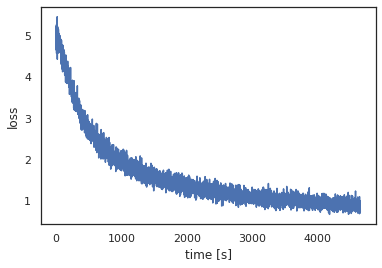

In [29]:
steps=5000
batch_size=256

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

losses = np.empty(steps)
time_start = time()

for step in range(1, steps+1):

    # Sample some pairs.
    idx1, idx2 = sample_pairs(n_samples, batch_size, style="knn")
    
    # Compute distances between projections
    p1 = [projections[i] for i in idx1]
    p2 = [projections[i] for i in idx2]
    
    distance_target = d_p(p1, p2)

    a1 = [angles_predicted[i] for i in idx1]
    a2 = [angles_predicted[i] for i in idx2]
    # Optimize by gradient descent.
    losses[step-1], gradients = gradient(a1, a2, distance_target, normalize=True)
    optimizer.apply_gradients(zip(gradients, a1 + a2))

    # Periodically report progress.
    if ((step % (steps//10)) == 0) or (step == steps):
        time_elapsed = time() - time_start
        print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')

# Plot convergence.
fig, ax = plt.subplots()
ax.plot(np.linspace(0, time()-time_start, steps), losses)
ax.set_xlabel('time [s]')
ax.set_ylabel('loss');

### [After] Prediction vs. True Angles

In [30]:
loss_predicted_vs_true_angle(steps=2000, batch_size=256)

step 200/2000 (2s): loss = 1.99e+00
step 400/2000 (3s): loss = 1.93e+00
step 600/2000 (5s): loss = 2.22e+00
step 800/2000 (6s): loss = 1.92e+00
step 1000/2000 (8s): loss = 1.94e+00
step 1200/2000 (10s): loss = 2.21e+00
step 1400/2000 (11s): loss = 2.02e+00
step 1600/2000 (13s): loss = 2.20e+00
step 1800/2000 (14s): loss = 1.98e+00
step 2000/2000 (16s): loss = 2.08e+00
Mean loss: 1.9882940394528554


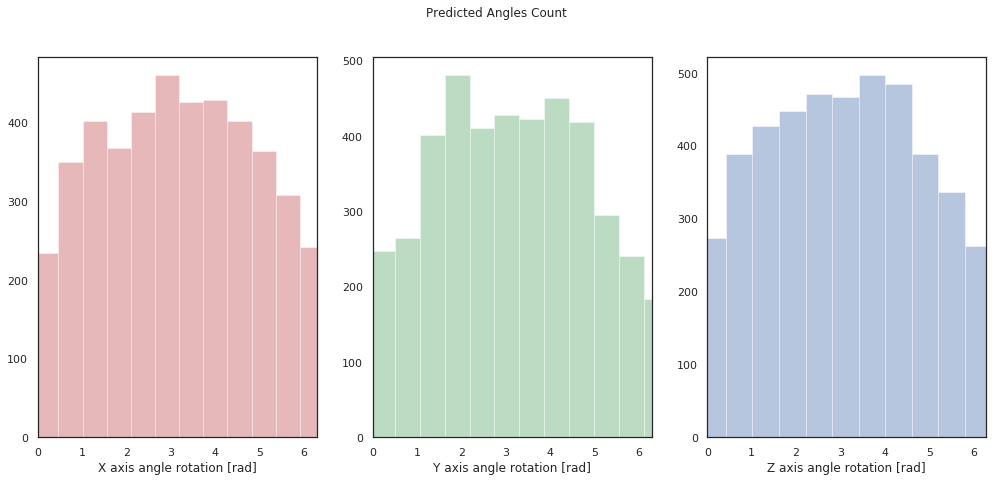

In [31]:
_angles_predicted = np.array([x.numpy() for x in angles_predicted])

fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,2*np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("Predicted Angles Count")

sns.distplot(_angles_predicted[:,0], kde=False, bins=20, ax=axs[0], axlabel="X axis angle rotation [rad]", color="r")
sns.distplot(_angles_predicted[:,1], kde=False, bins=20, ax=axs[1], axlabel="Y axis angle rotation [rad]", color="g")
sns.distplot(_angles_predicted[:,2], kde=False, bins=20, ax=axs[2], axlabel="Z axis angle rotation [rad]", color="b");

---

# Distributions